[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb)

# Install dependencies

## 1. graphviz libgraphviz-dev pkg-config

In [ ]:
!apt-get install graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


We need these prerequisite libraries to run a graph visualization library (`pygraphviz`). We will use this library during this notebook to understand the structure of our graphs _but_ it is not required to use `langgraph`.

## 2. Now we install Python libraries:

In [ ]:
!pip install -qU \
    datasets==2.19.1 \
    langchain-pinecone==0.1.1 \
    langchain-openai==0.1.9 \
    langchain==0.2.5 \
    langchain-core==0.2.9 \
    langgraph==0.1.1 \
    semantic-router==0.0.48 \
    serpapi==0.1.5 \
    google-search-results==2.4.2 \
    pygraphviz==1.12  # for visualizing

# Init everything

In [ ]:
from typing import TypedDict, Annotated, List, Union
import operator

import os
from getpass import getpass
from serpapi import GoogleSearch

from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END



serpapi_params = {
    "engine": "google",
    "api_key": os.getenv("SERPAPI_KEY") or getpass("SerpAPI key: ")
}


# Research Agent

## Graph State

We will define a custom graph state to support our agent-oriented decision making.

In [ ]:
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

There are four parts to our agent state, those are:

* `input`: this is the user's most recent query, usually this would be a question that we want to answer with our research agent.
* `chat_history`: we are building a conversational agent that can support multiple interactions, to allow previous interactions to provide additional context throughout our agent logic we include the chat history in the agent state.
* `intermediate_steps`: provides a record of all steps the research agent will take between the user asking a question via `input` and the agent providing a final answer. This can include things like "search arxiv", "perform general purpose web search", etc. These intermediate steps are crucial to allowing the agent to follow a path of coherent actions and ultimately producing an informed final answer.

## DefiningTools

We will define several tools for this agent that will focus on initial data discovery, that will allow the LLM to use more tools to research more deeply via a variety of different routes.

### Web Search

The web search tool will provide the agent with access to web search. It will be instructed to use this for more general knowledge queries.

Test search here:

In [ ]:
search = GoogleSearch({
    **serpapi_params,
    "q": "Dallas",
    "num": 3
})

results = search.get_dict()["organic_results"]

contexts = "\n---\n".join(
    ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
)

print(contexts)

Dallas
Dallas is a city in the U.S. state of Texas and the most populous city in the Dallas–Fort Worth metroplex, the most populous metropolitan area in Texas and ...
https://en.wikipedia.org/wiki/Dallas
---
Dallas TX: Top Attractions, Hotels, Restaurants & Insider Tips
Visit Dallas and explore the city's top things to do, places to eat, shopping and much more. Plan your trip with our guides, maps, weather and top insider ...
https://www.visitdallas.com/
---
Welcome to the City of Dallas, Texas
The City of Dallas home page has information about employment, elected officials, online services and city departments for residents and visitors.
https://www.dallascityhall.com/


Define tool:

In [ ]:
@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 5
    })
    results = search.get_dict()["organic_results"]
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

### Final Answer

Finally, we define a "final answer" tool. This isn't a tool in the usual sense, instead we use it to force a particular output format from our LLM via the function/tool calling.

In [ ]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

## Initialize the "Oracle"

The **Oracle** LLM is our graph's decision maker. It decides which path we should take down our graph. It functions similarly to an agent but is much simpler and reliable.

The Oracle consists of an LLM provided with a set of potential function calls (ie our tools) that it can decide to use — we force it to use _at least_ one of those tool using the `tool_choice="any"` setting (see below). Our Oracle only makes the decision to use a tool, it doesn't execute the tool code itself (we do that seperately in our graph).

### Oracle Prompt

Our prompt for the Oracle will emphasize it's decision making ability within the `system_prompt`, leave a placeholder for us to later insert `chat_history`, and provide a place for us to insert the user `input`.

In [ ]:
system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

Next, we must initialize our `llm` (for this we use `gpt-4o`) and then create the _runnable_ pipeline of our Oracle.

The runnable connects our inputs (the user `input` and `chat_history`) to our `prompt`, and our `prompt` to our `llm`. It is also where we _bind_ our tools to the LLM and enforce function calling via `tool_choice="any"`.

In [ ]:
llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

tools=[
    web_search,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

Test the agent quickly to confirm it is functional:

In [ ]:
inputs = {
    "input": "want to visit some nice vegan even in Dallas today",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rElg6zL3zNS8ns7ceFVVES2P', 'function': {'arguments': '{"query":"vegan events in Dallas October 2023"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 419, 'total_tokens': 442, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_898ac29719', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c4f791cd-9a59-49ff-9ec2-cd16303e9c5f-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'vegan events in Dallas October 2023'}, 'id': 'call_rElg6zL3zNS8ns7ceFVVES2P'}], usage_metadata={'input_tokens': 419, 'output_tokens': 23, 'total_tokens': 442})

It is running but we are returning a lot of output here, we can narrow this down to what we need — ie, the chosen tool name and generated input args for the tool.

In [ ]:
out.tool_calls[0]["name"]

{'query': 'vegan events in Dallas October 2023'}

In [ ]:
out.tool_calls[0]["args"]

{'query': 'vegan events in Dallas October 2023'}

## Define Nodes for Graph

We will be passing the tool use decision to our `router` which will _route_ the output to the chosen node component to run (we define these below) based on the `out.tool_calls[0]["name"]` value.

In [ ]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

All of our tools can be run using the same function logic, which we define with `run_tool`. The input parameters to our tool call and the resultant output are added to our graph state's `intermediate_steps` parameter.

In [ ]:
tool_str_to_func = {
    "web_search": web_search,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

## Define Graph

In [ ]:
graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

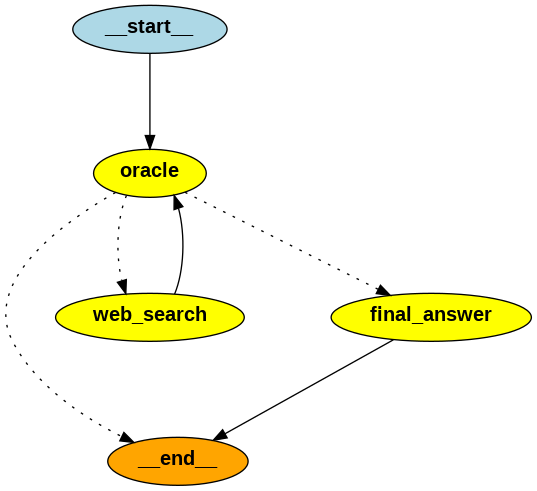

In [ ]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

## Building Reports

Let's test our research agent. First, I want to try on something simple (although not within the intended use-case of our agent):

In [ ]:
out = runnable.invoke({
    "input": "tell me some nice vegan places in Dallas",
    "chat_history": [],
})

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'vegan restaurants in Dallas'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'vegan restaurants in Dallas'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'vegan restaurants in Dallas'}, log="The Best Vegan Restaurants Around Dallas\nThe Best Vegan Restaurants Around Dallas · Recipe Oak Cliff · Spiral Diner & Bakery · Maiden · Casa Del Vegano · Vegan Food House · El Palote ...\nhttps://dallas.eater.com/maps/dallas-best-vegan-restaurants\n---\nThe Best Vegan Restaurants in Dallas: Our Picks\nVegan Spots in Dallas · Casa Del Vegano · Kalachandjis · HG Sply Co. · HopeBoy's Kitchen · Recipe Oak Cliff · Vegan Food House · Vegan Food House · Related ...\nhttps://www.visitdallas.com/blog/vegan-spots-in-dallas/\n---\nNice restaurants with good vegan options? : r/Dallas\nResident Taqueria in Lake Highlands has some solid vegan options they can make all their veggie tacos 

Let's create a function to consume the agent output and format it into our report:

In [ ]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [ ]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Dallas, a vibrant city known for its diverse culinary scene, offers a variety of vegan dining options for those seeking plant-based meals. Whether you're a local or a visitor, exploring vegan restaurants in Dallas can be a delightful experience.

RESEARCH STEPS
--------------
- Conducted a web search to identify popular vegan restaurants in Dallas.
- Reviewed multiple sources to gather a list of recommended vegan dining spots.
- Compiled information on the top vegan restaurants and their offerings.

REPORT
------
Dallas boasts a range of vegan restaurants that cater to different tastes and preferences. One of the top spots is Spiral Diner & Bakery, known for its extensive menu featuring classic American comfort food with a vegan twist. From burgers to milkshakes, Spiral Diner offers a nostalgic dining experience without animal products.

Another popular choice is Vegan Food House, which serves Southern-inspired vegan dishes. Their menu includes items like veg